# Task 2
Setup a NN to regress aco_angle_1 - this will give us some ideas about how we need to setup the NN in order for it to make use of the low-level information and then we can use a similar architecture for our final NN setup. After reading around online a bit one possible reason that the NN is not working very well is because the CP observables depend on what rest frame you determine them in and possibly the NN is not well setup to handle Lorentz boosts into different frames. I found a paper which suggest how to setup the first layers of a NN in order to perform such Lorentz boosts (https://arxiv.org/pdf/1812.09722.pdf) - this might be a good place to start, but of course if you have other ideas you are free to follow them

In [1]:
!pip install --user lbn
!pip install --user pylorentz

In [2]:
import uproot 
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from pylorentz import Momentum4
from pylorentz import Position4
from lbn import LBN, LBNLayer

In [3]:
# stop tensorflow trying to overfill GPU memory
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
  except RuntimeError as e:
    print(e)

In [4]:
# loading the tree
tree = uproot.open("/eos/user/d/dwinterb/SWAN_projects/Masters_CP/MVAFILE_GluGluHToTauTauUncorrelatedDecay_Filtered_tt_2018.root")["ntuple"]
#tree2 = uproot.open("/eos/user/d/dwinterb/SWAN_projects/Masters_CP/MVAFILE_VBFHToTauTauUncorrelatedDecay_Filtered_tt_2018.root")["ntuple"]


#These are new trees, added by Danny on 13/10
#tree3=uproot.open("/eos/user/d/dwinterb/SWAN_projects/Masters_CP/MVAFILE_AllHiggs_tt.root")["ntuple"]  
#note, instead of the first t we can have e,m, different decay modes

In [5]:
# define what variables are to be read into the dataframe

momenta_features = [ "pi_E_1", "pi_px_1", "pi_py_1", "pi_pz_1", #leading charged pi 4-momentum
              "pi_E_2", "pi_px_2", "pi_py_2", "pi_pz_2", #subleading charged pi 4-momentum
              "pi0_E_1","pi0_px_1","pi0_py_1","pi0_pz_1", #leading neutral pi 4-momentum
              "pi0_E_2","pi0_px_2","pi0_py_2","pi0_pz_2"] #subleading neutral pi 4-momentum

other_features = [ "ip_x_1", "ip_y_1", "ip_z_1",        #leading impact parameter
                   "ip_x_2", "ip_y_2", "ip_z_2",        #subleading impact parameter
                   "y_1_1", "y_1_2"]    # ratios of energies

target = [    "aco_angle_1"]  #acoplanarity angle
    
selectors = [ "tau_decay_mode_1","tau_decay_mode_2",
             "mva_dm_1","mva_dm_2"
             ]

df = tree.pandas.df(momenta_features+other_features+target+selectors)

df = df[
      (df["tau_decay_mode_1"] == 1) 
    & (df["tau_decay_mode_2"] == 1) 
    & (df["mva_dm_1"] == 1) 
    & (df["mva_dm_2"] == 1)
]
#df2 = tree2.pandas.df(variables)

#tree3 should be more comprehensive and complete as it includes all decay types and more
#info for tau->a1 decays. Again we save the same variables for now

#df3 = tree3.pandas.df(variables)

#combine VBF and ggH events

#df = pd.concat([df,df2], ignore_index=True)

In [6]:
df.head()

,pi_E_1,pi_px_1,pi_py_1,pi_pz_1,pi_E_2,pi_px_2,pi_py_2,pi_pz_2,pi0_E_1,pi0_px_1,...,ip_x_2,ip_y_2,ip_z_2,y_1_1,y_1_2,aco_angle_1,tau_decay_mode_1,tau_decay_mode_2,mva_dm_1,mva_dm_2
entry,,,,,,,,,,,,,,,,,,,,,
4,26.184192,5.249920,-12.394966,-22.458754,52.305565,-10.016787,40.401790,-31.673523,95.932667,20.387663,...,-0.000894,0.000668,0.000903,0.571162,-0.773942,5.927902,1,1,1,1
15,3.912128,3.186334,0.086207,-2.263873,32.211659,7.872188,29.660602,9.790244,64.282235,52.942869,...,-0.002586,0.001020,-0.000611,0.885265,-0.339467,5.015406,1,1,1,1
26,20.389432,12.846308,15.714182,1.935544,5.313678,-4.517069,-2.251007,1.656731,35.041365,21.823335,...,0.004199,0.003093,0.014879,0.264328,0.760691,3.019532,1,1,1,1
39,4.532329,-1.060811,2.501133,-3.625128,11.348225,-2.284085,-6.326895,-9.138714,102.977036,-25.022726,...,0.009565,-0.000590,-0.001876,0.915685,0.772376,2.650678,1,1,1,1
55,77.929050,28.100279,42.522791,58.950012,72.891011,8.689332,15.745896,70.637400,68.260095,25.125369,...,-0.020295,0.027176,-0.004810,-0.066140,0.534360,3.057700,1,1,1,1


In [7]:
# Create our 4-vectors in the lab frame
pi_1 = Momentum4(df["pi_E_1"], df["pi_px_1"], df["pi_py_1"], df["pi_pz_1"])
pi_2 = Momentum4(df["pi_E_2"], df["pi_px_2"], df["pi_py_2"], df["pi_pz_2"])

#TODO: maybe remove these and uncomment above:
IP1 = Momentum4(df["pi0_E_1"], df["pi0_px_1"], df["pi0_py_1"], df["pi0_pz_1"])
IP2 = Momentum4(df["pi0_E_2"], df["pi0_px_2"], df["pi0_py_2"], df["pi0_pz_2"])


# Create 4-vectors in the ZMF
pi_T4M = pi_1 + pi_2

pi1_ZMF = pi_1.boost_particle(-pi_T4M)
pi2_ZMF = pi_2.boost_particle(-pi_T4M)

IP1_ZMF = IP1.boost_particle(-pi_T4M)
IP2_ZMF = IP2.boost_particle(-pi_T4M)

# Find the transverse components
IP1_trans = np.cross(IP1_ZMF[1:,:].transpose(), pi1_ZMF[1:, :].transpose())
IP2_trans = np.cross(IP2_ZMF[1:,:].transpose(), pi2_ZMF[1:, :].transpose())


# Normalise the vectors
IP1_trans = IP1_trans/np.linalg.norm(IP1_trans, ord=2, axis=1, keepdims=True)
IP2_trans = IP2_trans/np.linalg.norm(IP2_trans, ord=2, axis=1, keepdims=True)



#Calculate Phi_ZMF using dot product and arccos
dot = np.sum(IP1_trans*IP2_trans, axis=1)
Phi_ZMF = np.arccos(dot)

# Calculate O
x = np.cross(IP1_trans, IP2_trans).transpose()*np.array(pi2_ZMF[1:, :])
big_O = np.sum(x, axis=0)
# Shift Phi based on O's sign
Phi_Shift1=np.where(big_O<0, Phi_ZMF, 2*np.pi-Phi_ZMF)

# Shift phi based on energy ratios
y_T = np.array(df['y_1_1']*df['y_1_2'])
Phi_Shift2=np.where(y_T<0, Phi_Shift1, np.where(Phi_Shift1<np.pi, Phi_Shift1+np.pi, Phi_Shift1-np.pi))

In [8]:
# Create x and y tensors
#TODO: remove target
x = np.array([Phi_Shift1, y_T]).transpose()

# Reshape for LBN
#x = tf.reshape(x, (x.shape[0], 4, 4))
#x = x.reshape(x.shape[0], 4, 4,)

y = np.array(df[target], dtype=np.float32)

In [9]:
#features for LBN output
LBN_output_features = ["E", "px", "py", "pz", "m", "pair_dy", "pair_cos"]

#define NN model and compile
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(8, activation='relu', input_shape=(2,)),
    tf.keras.layers.Dense(1)
])

loss_fn = tf.keras.losses.MeanSquaredError()
model.compile(optimizer='Adam',
              loss=loss_fn,
              metrics=['mae'])

W1019 17:54:33.809240 140358812145472 deprecation.py:506] From /cvmfs/sft.cern.ch/lcg/views/LCG_97apython3/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 24        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 33
Trainable params: 33
Non-trainable params: 0
_________________________________________________________________


In [11]:
#train model
history = model.fit(x, y, validation_split=0.3, epochs=20)

Train on 101840 samples, validate on 43647 samples
Epoch 1/20
101840/101840 [==============================] - 6s 57us/sample - loss: 2.2733 - mean_absolute_error: 1.2073 - val_loss: 1.3917 - val_mean_absolute_error: 0.9041
Epoch 2/20
101840/101840 [==============================] - 6s 60us/sample - loss: 1.2611 - mean_absolute_error: 0.8451 - val_loss: 1.1491 - val_mean_absolute_error: 0.7988
Epoch 3/20
101840/101840 [==============================] - 6s 57us/sample - loss: 1.0877 - mean_absolute_error: 0.7691 - val_loss: 1.0259 - val_mean_absolute_error: 0.7397
Epoch 4/20
101840/101840 [==============================] - 6s 57us/sample - loss: 0.9875 - mean_absolute_error: 0.7300 - val_loss: 0.9446 - val_mean_absolute_error: 0.7128
Epoch 5/20
101840/101840 [==============================] - 6s 57us/sample - loss: 0.9201 - mean_absolute_error: 0.7067 - val_loss: 0.8886 - val_mean_absolute_error: 0.6966
Epoch 6/20
101840/101840 [==============================] - 5s 46us/sample - loss: 0

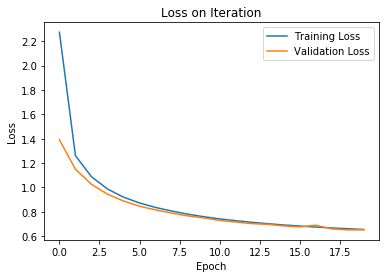

In [12]:
#plot traning
plt.figure()
plt.plot(history.history['loss'], label="Training Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.title("Loss on Iteration")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

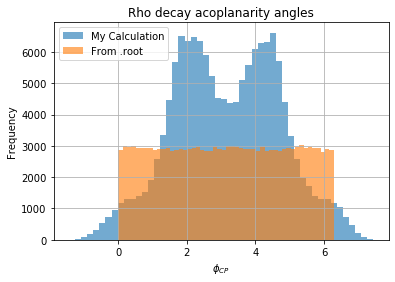

In [13]:
#Infer on full dataset
#TODO: only infer on validation set
Phi_CP = np.array(model.predict(x)).reshape(x.shape[0])

#Plot the histogram
aco_angle_1 = np.array(df['aco_angle_1'])

plt.figure()
plt.title("Rho decay acoplanarity angles")
plt.hist(Phi_CP, label="My Calculation", alpha=0.625, bins=50)
plt.hist(np.array(y), label="From .root", alpha=0.625, bins=50)
plt.xlabel(r"$\phi_{CP}$")
plt.ylabel("Frequency")
plt.grid()
plt.legend()
plt.savefig("KingsleyTask1.png")
plt.show()
plt.close()

In [14]:
#print the first few results vs given angles
y_print = np.array(y).reshape(y.shape[0])
for i in range(10):
    print("{} \t {}".format(Phi_CP[i], y_print[i]))

6.444684028625488 	 5.927901744842529
4.93155574798584 	 5.015406131744385
2.5800979137420654 	 3.0195324420928955
1.5594661235809326 	 2.6506776809692383
3.2930009365081787 	 3.0576999187469482
4.367798805236816 	 5.388603210449219
3.840968370437622 	 5.058131217956543
2.3399035930633545 	 3.4759140014648438
4.756972312927246 	 5.67650842666626
4.067694664001465 	 4.645352840423584
